### HW 8 - KNN
Katie Corcoran

#### 0. Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
randomstate = 1000

df = pd.read_csv('bikeshare.csv')
df.drop(['dteday'], axis=1, inplace=True)
df.head()

,season,yr,mnth,hr,holiday,weekday,notbizday,weathersit,temp,hum,windspeed,cnt
0,1,0,1,0,0,6,1,1,-1.334609,0.947345,-1.553844,16
1,1,0,1,1,0,6,1,1,-1.438475,0.895513,-1.553844,40
2,1,0,1,2,0,6,1,1,-1.438475,0.895513,-1.553844,32
3,1,0,1,3,0,6,1,1,-1.334609,0.636351,-1.553844,13
4,1,0,1,4,0,6,1,1,-1.334609,0.636351,-1.553844,1


### Question 1: KNN Regression

#### 1. Define target variable and feature space

In [2]:
from sklearn.model_selection import train_test_split

target = df['cnt']
X = df.drop(['cnt'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=randomstate)
X_train.head()

,season,yr,mnth,hr,holiday,weekday,notbizday,weathersit,temp,hum,windspeed
2136,2,0,4,21,0,0,1,2,-0.399817,-0.970450,0.276298
5466,3,0,8,16,0,6,1,1,1.573634,-0.866786,0.031898
8770,1,1,1,6,0,5,0,2,-1.438475,0.532687,-0.699669
14674,3,1,9,15,0,6,1,3,0.327244,1.310171,0.519881
15708,4,1,10,17,0,0,1,1,0.119512,-1.229612,0.519881


#### 2. KNN Regression

1. Train the model

In [3]:
from sklearn.neighbors import KNeighborsRegressor

KNN_regression = KNeighborsRegressor()
KNN_regression.fit(X_train, y_train)

KNeighborsRegressor()

2. Make predictions

In [4]:
y_hat = KNN_regression.predict(X_test)

3. Construct dataframe

In [5]:
predictions = pd.DataFrame({ 'y_test':y_test,'y_hat':y_hat})
predictions.head()

,y_test,y_hat
4495,26,37.8
4418,47,58.6
7141,11,13.2
14765,205,217.6
16541,65,85.8


3. Scatterplot

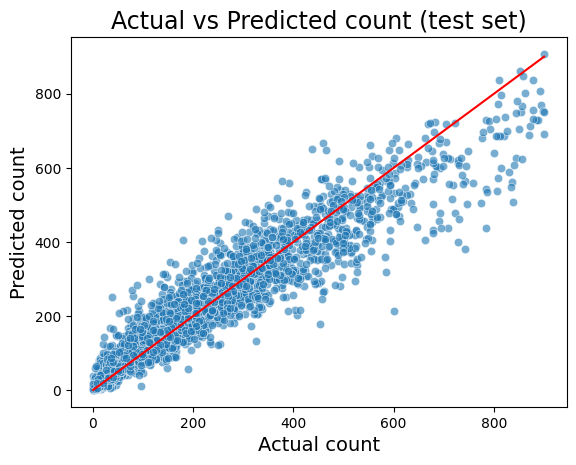

In [6]:
sns.scatterplot(x='y_test', y='y_hat', alpha=0.6, data=predictions)
sns.lineplot(x='y_test', y='y_test', data=predictions, color='red')

plt.xlabel('Actual count', fontsize=14)
plt.ylabel('Predicted count', fontsize=14)
plt.title('Actual vs Predicted count (test set)', fontsize=17)
plt.show()

Based on this scatterplot, the model seems to perform reasonably well for lower counts, but there starts to be some spread at higher counts. A more complex or better tuned model could help reduce the error for higher counts.

4. RMSE_test

In [7]:
MSE_test = round(np.mean(np.square(y_test - y_hat)),2)
RMSE_test = round(np.sqrt(MSE_test),2)
print('RMSE_test:', RMSE_test)

RMSE_test: 56.97


#### 3. Cross Validation

1. 5-fold RMSE_test

In [8]:
from sklearn.model_selection import cross_val_score

NMSE = cross_val_score(estimator = KNN_regression, X = X_train, y = y_train, cv = 5 , scoring="neg_mean_squared_error" )
MSE_CV = round(np.mean(-NMSE),4)
RMSE_CV = round(np.sqrt(MSE_CV), 4)
print('RMSE_CV:', RMSE_CV)

RMSE_CV: 60.9211


2. Find the optimal value for K

In [9]:
RMSE_CV=[]
RMSE_test = []

k=100

for i in range(1,k):
    KNN_i = KNeighborsRegressor(n_neighbors=i)
    KNN_i.fit(X_train, y_train)
    MSE_i = np.mean(-1*cross_val_score(estimator = KNN_i, X = X_train, y = y_train, cv = 10 , scoring="neg_mean_squared_error" ))
    RMSE_CV.append(np.sqrt(MSE_i))
    RMSE_test.append(np.sqrt(np.mean(np.square(y_test - KNN_i.predict(X_test)))))
    
optimal_k = pd.DataFrame({'RMSE_CV': np.round(RMSE_CV,4), 'RMSE_test':np.round(RMSE_test,4), 'K':range(1,k)})

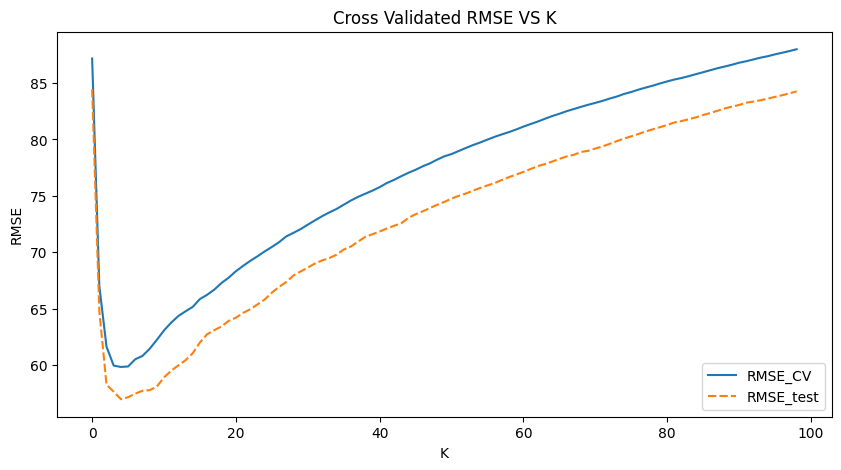

In [10]:
plt.figure(figsize=(10,5))
sns.lineplot(data=optimal_k.drop('K', axis=1))
plt.title('Cross Validated RMSE VS K')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.show()

In [11]:
optimal_k_index = np.argmin(optimal_k['RMSE_CV'])
RMSE_test_optimal = optimal_k.loc[optimal_k_index, 'RMSE_test']

In [12]:
from sklearn.linear_model import LinearRegression

# Train a multiple linear regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Make predictions on the test set
y_hat_linear = reg_model.predict(X_test)
test_predictions = pd.DataFrame({'actuals':y_test, 'predictions':y_hat, 'resid': y_test - y_hat})

# Calculate R-squared for the linear model
MSE_test = np.mean(np.square(test_predictions['resid']))
RMSE_test = np.sqrt(MSE_test)
RMSE_test_linear = np.round(RMSE_test,4)
print('KNN Regression K=5 RMSE_test:', RMSE_test_optimal)
print('Linear Regression RMSE_test:', RMSE_test_linear)

KNN Regression K=5 RMSE_test: 56.9672
Linear Regression RMSE_test: 56.9672


Both models are performing the same in the test set with RMSE_test = 56.97. This is likely an indicator that the underlying relationship in the data is linear, and it would be best to use a linear model for simplicity and performance.

### Question 2: KNN Classification

#### 1. Overload variable

In [13]:
import numpy as np
df['overload'] = np.where(df['cnt']>500, 1, 0)
target = df['overload']
pd.crosstab(target, target, normalize='all')*100

overload,0,1
overload,,
0,92.640543,0.000000
1,0.000000,7.359457


Our target variable 'overload' is highly imbalanced, with only 7.3% of the data equal to 1.

#### 2. Train and test split

In [14]:
X = df.drop(['overload', 'cnt'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=randomstate)
X_train.head()

,season,yr,mnth,hr,holiday,weekday,notbizday,weathersit,temp,hum,windspeed
2243,2,0,4,8,0,5,0,3,-0.815280,1.258339,-0.211685
17261,1,1,12,2,0,4,0,2,-1.334609,1.258339,2.106440
435,1,0,1,4,0,4,0,1,-1.230743,-0.348463,-0.211685
785,1,0,2,4,0,6,1,3,-1.438475,1.569333,-0.456086
6360,4,0,9,14,0,2,0,2,0.950439,0.843681,-0.699669


#### 3. KNN Classification

1. Train the model

In [15]:
from sklearn.neighbors import KNeighborsClassifier

KNN_classifier = KNeighborsClassifier()
KNN_classifier.fit(X_train, y_train)

KNeighborsClassifier()

2. Predicted probabilities

In [16]:
y_hat = KNN_classifier.predict(X_test)
y_hat_probs = KNN_classifier.predict_proba(X_test)[:,1]

3. Plot y_hat_probs

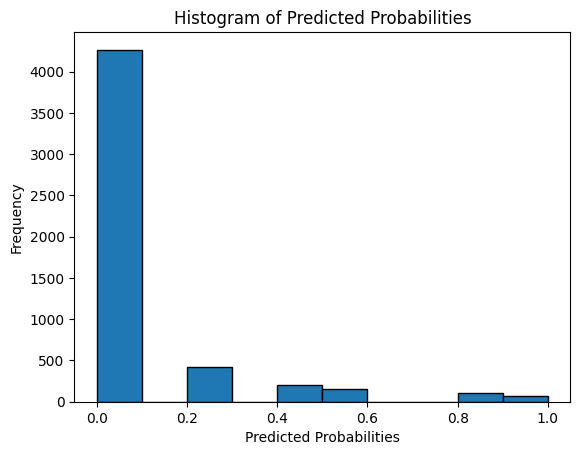

In [17]:
plt.hist(y_hat_probs, bins=10, edgecolor='k')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.show()

From this histogram, the model is most often predicting a very low probability of overload. Above a threshold of around 40%, the model will almost always predict overload=false.

4. 30% and 70% thresholds

In [18]:
y_hat_30 = np.where(y_hat_probs>0.30,1,0)
y_hat_70 = np.where(y_hat_probs>0.70,1,0)

To avoid too many false negatives I would choose a threshold of 30%, because a lower threshold makes the model more likely to predict overload=true. If the threshold were 70%, the model would almost always predict overload=false, which would lead to more false negatives.

5. df_predictions

In [19]:
df_predictions = pd.DataFrame({'y_test': y_test, 'y_hat': y_hat, 'y_hat_probs': y_hat_probs, 'y_hat_30': y_hat_30, 'y_hat_70': y_hat_70})
df_predictions.head()

,y_test,y_hat,y_hat_probs,y_hat_30,y_hat_70
4495,0,0,0.0,0,0
4418,0,0,0.0,0,0
7141,0,0,0.0,0,0
14765,0,0,0.0,0,0
16541,0,0,0.0,0,0


#### 4. KNN Report

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef



def my_KNN_report(X_train, y_train, X_test,y_test, K=5, threshold=0.5, weights='uniform'):
    knn= KNeighborsClassifier(n_neighbors=K, weights=weights)
    knn.fit(X_train, y_train)
    probs = knn.predict_proba(X_test)[:,1]
    y_hat = np.where(probs>=threshold,1,0)
    
    cm = confusion_matrix(y_test, y_hat)
    accuracy = round(accuracy_score(y_test,y_hat) ,4)
    precision = round(precision_score(y_test,y_hat),2)
    recall = round(recall_score(y_test,y_hat),2)
    f1score = round(f1_score(y_test,y_hat),2)
    cm_labled = pd.DataFrame(cm, index=['Actual : negative ','Actual : positive'], columns=['Predict : negative','Predict :positive '])
    
    print("-----------------------------------------")
    print('Accuracy  = {}'.format(accuracy))
    print('Precision = {}'.format(precision))
    print('Recall    = {}'.format(recall))
    print('f1_score  = {}'.format(f1score))
    print("-----------------------------------------")
    return cm_labled

1. 0.5 Threshold

In [21]:
my_KNN_report(X_train, y_train, X_test, y_test)

-----------------------------------------
Accuracy  = 0.9605
Precision = 0.79
Recall    = 0.65
f1_score  = 0.71
-----------------------------------------


,Predict : negative,Predict :positive
Actual : negative,4750,69
Actual : positive,137,258


**Accuracy:** An accuracy of 96% means that this model is classifying overload correctly 96% of the time.\
**Precision:** The precision of 79% means that of all predicted overloads, 79% were correct.\
**Recall:** The recall of 65% means that the model identifies 65% of actual overloads.\
**F1-score:** The f1 score is the harmonic mean of precision and recall. Precision is higher, but is being dragged down by a low recall.\
**Confusion Matrix:** The confusion matrix tells us how many true and false negatives and true and false positives were predicted. In this case we have a relatively high number of false negatives (predicting no overload when there was an overload), which makes sense since our model is predicting almost all observations as no default.

No, I do not trust the accuracy for this model because it is highly skewed by the imbalanced target variable. The other performance metrics indicate the model is doing just okay.

2. 0.30 Threshold

In [22]:
my_KNN_report(X_train, y_train, X_test, y_test, threshold=0.3)

-----------------------------------------
Accuracy  = 0.9494
Precision = 0.62
Recall    = 0.83
f1_score  = 0.71
-----------------------------------------


,Predict : negative,Predict :positive
Actual : negative,4621,198
Actual : positive,66,329


With threshold 0.30, accuracy and precision go down, but recall goes up. This is because the model is predicting more false positives but fewer false negatives, so precision tells us that of all predicted overloads, only 62% were true overloads. However, the higher recall tells us that the model is correctly predicting 83% of actual overloads. The F1 score remains the same, which tells us that the balance between precision and recall in the two models remain the same, but the tradeoff has shifted. This aligns with my answer in question 3.4 when I said that a threshold of 0.3 would reduce false negatives.

#### 5. ROC Curve

No Skill: ROC AUC=0.500
KNN: ROC AUC=0.956


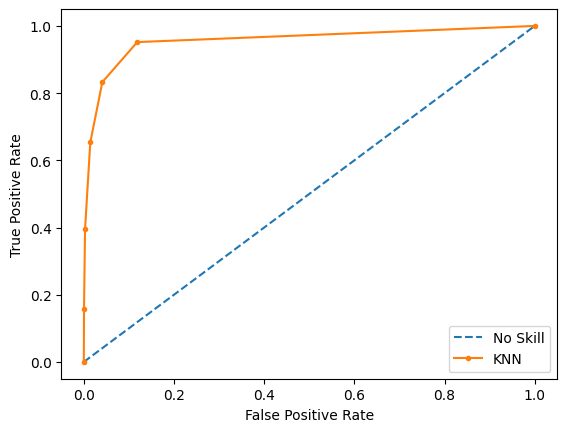

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score

# generate a no skill (ns) prediction and KNN  (lr) predictions.
ns_probs = [1 for i in range(len(y_test))]
lr_probs = KNN_classifier.predict_proba(X_test)[:,1]
# calculating scores for no skill and KNN 
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('KNN: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='KNN')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Yes, my model is performing better than a random prediction, because the area under the curve is higher than 0.50.

#### 6. Cross Validation

1. Estimate error rate

In [24]:
from sklearn.model_selection import cross_val_score

k = 50
error_rate_CV = []
for i in range(1,k):
    KNN_i = KNeighborsClassifier(n_neighbors=i)
    KNN_i.fit(X_train, y_train)
    accuracy = cross_val_score(estimator=KNN_i, X=X_train, y=y_train, cv=5, scoring="accuracy")
    error_rate_CV.append(np.mean(1-accuracy))
    
optimal_k = pd.DataFrame({'error_rate_CV': error_rate_CV}, index=range(1,k))

2. Plot error rate

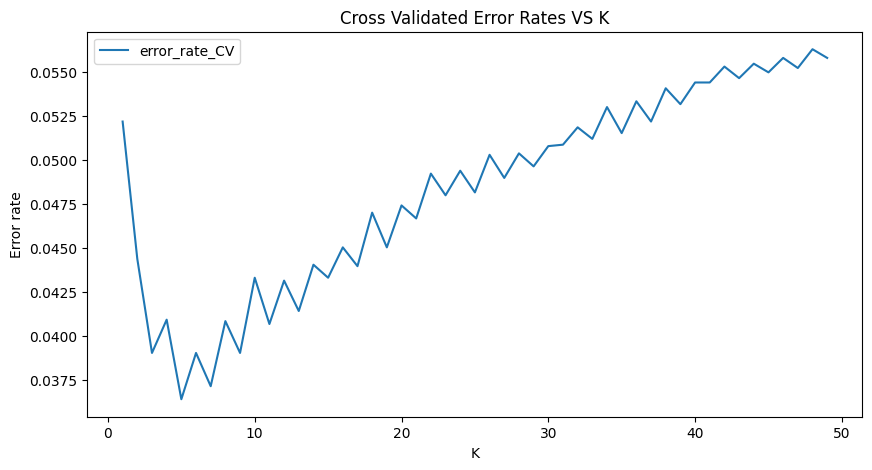

In [25]:
plt.figure(figsize=(10,5))
sns.lineplot(data=optimal_k)
plt.title('Cross Validated Error Rates VS K')
plt.xlabel('K')
plt.ylabel('Error rate')
plt.show()

7. Because the cost of an idle bike is smaller than the cost of an unexpected overload, it would be better to plan for more overloads even if the prediction ends up being false. In other words, we want to reduce false negatives because we would rather predict an overload and have too many idle bikes than have an unexpected overload. I would set a threshold of 0.3 because a lower threshold will produce less false negatives.